In [73]:
import sys
sys.path.append("..")

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from coda.utils.postprocessing import (
    load_data_assimilation_network,
    load_hydra_config,
    reconstruct_observations,
)
from coda.datamodule.DataLoader import L96InferenceDataset
from coda.datamodule.observational_models import RandomObservationModel
from mdml_tools.simulators.lorenz96 import L96Simulator

In [6]:
experiment_dir = "/gpfs/work/zinchenk/final_experiments/da_imperfect_forward_operator/pretrain_data_assimilation/multirun/2024-03-14/03-19-59/0"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"
drop_edge_samples = True

In [7]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [8]:
assimilation_network = load_data_assimilation_network(experiment_dir, device=device)
config = load_hydra_config(experiment_dir)

In [9]:
torch.manual_seed(random_seed)
pl.seed_everything(random_seed)

# instantiate observational model
observational_model = RandomObservationModel(
    additional_noise_std=config.datamodule.dataset.additional_noise_std,
    random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
)

# instantiate dataset
dataset = L96InferenceDataset(
    ground_truth_data=test_simulations,
    observation_model=observational_model,
    input_window_extend=config.input_window_extend,
    drop_edge_samples=drop_edge_samples,
)

print(f"Number of samples: {len(dataset)}")

Global seed set to 2510


Number of samples: 951


In [62]:
n_timesteps = 500

ground_truth = dataset.ground_truth[:, :n_timesteps].cpu()

observations = torch.zeros_like(ground_truth)
observations[:, :n_timesteps] = dataset.observations[:, :n_timesteps].cpu()
# cover missing values with np.nan
is_missing = torch.eq(observations, 0.)
observations = observations.masked_fill(is_missing, np.nan)

analysis = reconstruct_observations(dataset, assimilation_network).cpu()
li = config.input_window_extend
_analysis = torch.full_like(ground_truth, np.nan)
_analysis[:, li:n_timesteps-li] = analysis[:, :n_timesteps-2*li]
analysis = _analysis

difference = ground_truth - analysis

In [66]:
squared_errors = difference**2
mean_errors = squared_errors.mean((-1, 0)).sqrt()
std_errors = squared_errors.mean((-1)).sqrt().std((0))

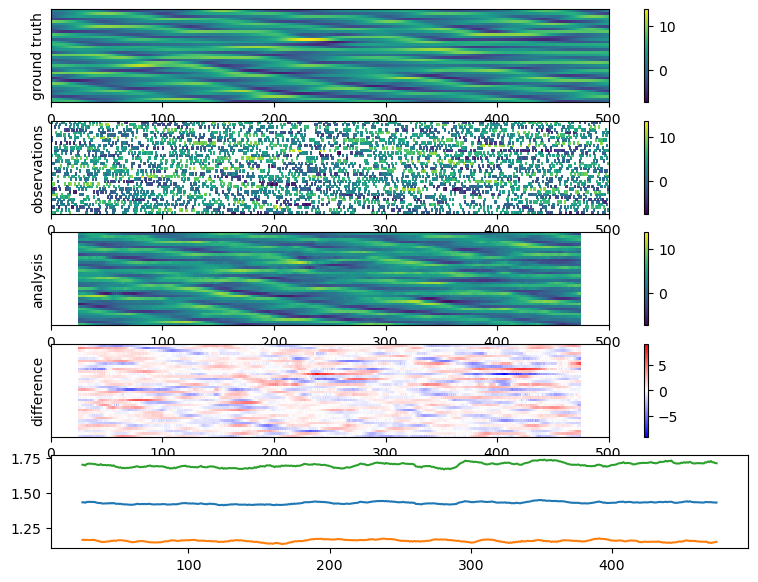

In [72]:
id_simulation = 1
mosaic = """
aa
bb
cc
dd
ee
"""
fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(9, 7))

tmp = torch.stack([ground_truth[id_simulation], observations[id_simulation], analysis[id_simulation]])
vmin = torch.nan_to_num(tmp, nan=9999).min()
vmax = torch.nan_to_num(tmp, nan=0).max()

# A - ground truth
img_gt = axd["a"].pcolor(ground_truth[id_simulation].T, vmin=vmin, vmax=vmax)
plt.colorbar(img_gt, ax=axd["a"])
# axd["a"].set_xticklabels(xtickslabels)
axd["a"].set_ylabel("ground truth")
axd["a"].tick_params(left=False, labelleft=False)

# B - observations
img_obs = axd["b"].pcolor(observations[id_simulation].T, vmin=vmin, vmax=vmax)
plt.colorbar(img_obs, ax=axd["b"])
# axd["a"].set_xticklabels(xtickslabels)
axd["b"].set_ylabel("observations")
axd["b"].tick_params(left=False, labelleft=False)

# C - analysis
img_a = axd["c"].pcolor(analysis[id_simulation, ].T, vmin=vmin, vmax=vmax)
plt.colorbar(img_a, ax=axd["c"])
# axd["a"].set_xticklabels(xtickslabels)
axd["c"].set_ylabel("analysis")
axd["c"].tick_params(left=False, labelleft=False)

# D - difference
vlim = torch.nan_to_num(difference[id_simulation], nan=0).abs().max()
img_diff = axd["d"].pcolor(difference[id_simulation].T, vmin=-vlim, vmax=vlim, cmap="bwr")
plt.colorbar(img_diff, ax=axd["d"])
# axd["a"].set_xticklabels(xtickslabels)
axd["d"].set_ylabel("difference")
axd["d"].tick_params(left=False, labelleft=False)

# E - squared errors
axd["e"].plot(mean_errors)
axd["e"].plot(mean_errors-std_errors)
axd["e"].plot(mean_errors+std_errors)